In [1]:
import numpy as np
import os
import re
from Corrfunc.utils import convert_rp_pi_counts_to_wp
from Corrfunc.theory import DDrppi

calculate the wp

In [2]:
import pickle
with open('c_c_pair_count.bin', 'rb') as f:
    result_dict = pickle.load(f)
calc = result_dict[(1,1)]
vol = np.pi*(calc['rmax']**2 - calc['rmin']**2)*1           # delta r pi = 1

In [3]:
boxsize = 2500
NR = 1000_000_000
n = NR / (boxsize**3)
RR = calc.copy()
RR['npairs'] = (NR*vol*n*2).astype('uint64')            # this has been cross checked to be correct

In [4]:
NDs = np.load('halo_mass_function.npy')['count']
logMh_N = len(NDs)

In [5]:
pimax = 100
Nbins = len(RR['npairs'])//pimax

In [6]:
wp_array = np.zeros(logMh_N*(logMh_N+1)//2, dtype=[('i', int), ('j', int), ('wp', float, Nbins)])
cnt = 0
for i in range(logMh_N):
    for j in range(i+1):
        wp_array['i'][cnt] = i+1
        wp_array['j'][cnt] = j+1
        if (i+1,j+1) not in result_dict:
            print(i,j)
            wp_array['wp'][cnt] = 0
            cnt += 1
            continue
        ND1 = NDs[i]
        ND2 = NDs[j]
        D1R2 = RR.copy()
        D1R2['npairs'] = ND1*vol*n*2
        D2R1 = RR.copy()
        D2R1['npairs'] = ND2*vol*n*2
        R1R2 = RR
        D1D2 = result_dict[(i+1,j+1)]
        wp_array['wp'][cnt] = convert_rp_pi_counts_to_wp(ND1, ND2, NR, NR, D1D2, D1R2, D2R1, R1R2, pimax=pimax, nrpbins=Nbins)
        cnt += 1

In [7]:
wp_array

array([(  1,   1, [ 4.22223452e+01,  3.29824002e+01,  3.75382069e+01,  3.68879691e+01,  3.78004955e+01,  3.49698014e+01,  3.86820439e+01,  3.48491479e+01,  3.28587258e+01,  3.01813276e+01,  2.79373477e+01,  2.46339440e+01,  2.14141957e+01,  1.92260724e+01,  1.73111777e+01,  1.47002712e+01,  1.28228535e+01,  1.09107346e+01,  9.06202802e+00,  7.39437582e+00,  5.88757222e+00,  4.64898529e+00,  3.45897718e+00,  2.54034903e+00,  1.79816930e+00,  1.20243766e+00,  7.95684193e-01,  5.01216615e-01,  3.11033717e-01,  1.96376412e-01]),
       (  2,   1, [ 3.37384078e+01,  2.51341913e+01,  3.55992318e+01,  1.43440508e+01,  2.96603929e+01,  2.75581084e+01,  1.61048826e+01,  2.83598286e+01,  1.64038161e+01,  2.26252143e+01,  2.11295747e+01,  1.51880231e+01,  1.22129336e+01,  1.42013611e+01,  1.31901210e+01,  1.41161805e+01,  1.19156680e+01,  1.11279844e+01,  9.05093977e+00,  7.24359765e+00,  5.76592251e+00,  4.48764568e+00,  3.57601732e+00,  2.35181705e+00,  1.75029854e+00,  1.25798312e+00,  6.64844

In [8]:
def ij2index(i, j):
    """
    Convert i, j to index of wp_array.
    wp_array is ordered as below:
    i       j
    1       1
    2       1
    2       2
    3       1
    3       2
    3       3
    4       1
    4       2
    ...
    """
    new_i = np.maximum(i, j)
    new_j = np.minimum(i, j)
    i = new_i
    j = new_j
    return i*(i-1)//2 + j-1

In [10]:
ij2index([1, 2], [3, 4])

array([3, 7])

In [11]:
wp_array_2 = np.zeros((logMh_N, logMh_N, Nbins))
for i in range(logMh_N):
    for j in range(i+1):
        if (i+1,j+1) not in result_dict:
            print(i,j)
            continue
        ND1 = NDs[i]
        ND2 = NDs[j]
        D1R2 = RR.copy()
        D1R2['npairs'] = ND1*vol*n*2
        D2R1 = RR.copy()
        D2R1['npairs'] = ND2*vol*n*2
        R1R2 = RR
        D1D2 = result_dict[(i+1,j+1)]
        wp = convert_rp_pi_counts_to_wp(ND1, ND2, NR, NR, D1D2, D1R2, D2R1, R1R2, pimax=pimax, nrpbins=Nbins)

        wp_array_2[i,j] = wp
        wp_array_2[j,i] = wp

In [20]:
np.save('2h_cc_wp.npy', wp_array_2)

In [19]:
np.isclose(wp_array_2[2, 3], wp_array[ij2index(3, 4)]['wp'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

cross check the DR and RR

In [6]:
boxsize = 2500
X = np.random.uniform(0, boxsize, 1_000_000_0)
Y = np.random.uniform(0, boxsize, 1_000_000_0)
Z = np.random.uniform(0, boxsize, 1_000_000_0)

In [11]:
sep_min = 0.1
sep_max = 100
sep_N = 30

pimax = 140
boxsize = 2500

r_pbins = np.geomspace(sep_min, sep_max, sep_N+1)

NR = 1000_000_0
n = NR / (boxsize**3)

In [ ]:
RR = calc.copy()
RR['npairs'] = (NR*vol*n*2).astype('uint64')
RR_real = DDrppi(1, 40, pimax, r_pbins, X1=X, Y1=Y, Z1=Z, periodic=True, boxsize=boxsize, verbose=False)
RR['npairs']/RR_real['npairs']

In [ ]:
bins = np.arange(logMh_N+1) * logMh_bin + logMh_m
res = np.digitize(np.log10(halos['M_h']), bins)
halos = np.load('main_halo_zspace.npy')
halo1 = halos[res == 1]
DR_real = DDrppi(0, 40, pimax, r_pbins, X1=X, Y1=Y, Z1=Z, X2=halo1['X'], Y2=halo1['Y'], Z2=halo1['Z'], periodic=True, boxsize=boxsize, verbose=False)
D1R2 = RR.copy()
D1R2['npairs'] = len(halo1)*vol*n*2
D1R2['npairs'] / DR_real['npairs']

check the result

In [10]:
sep_min = 0.1
sep_max = 100
sep_N = 30
r_pbins = np.geomspace(sep_min, sep_max, sep_N+1)
r_p = (r_pbins[1:]*r_pbins[:-1])**0.5

In [16]:
wp_array = np.load('halo_halo_auto_corr_table.npy')

In [11]:
import matplotlib.pyplot as plt

[]

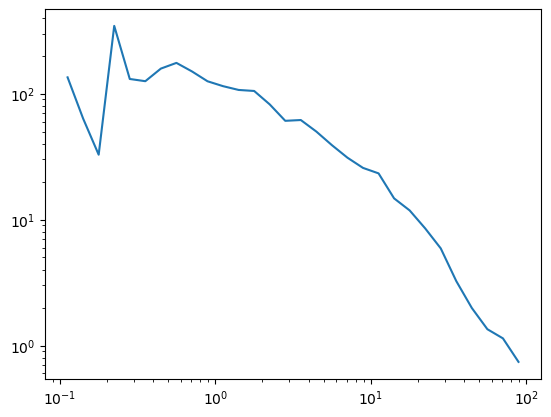

In [12]:
plt.plot(r_p, wp_array[ij2index(75, 75)]['wp'])
plt.loglog()

[]

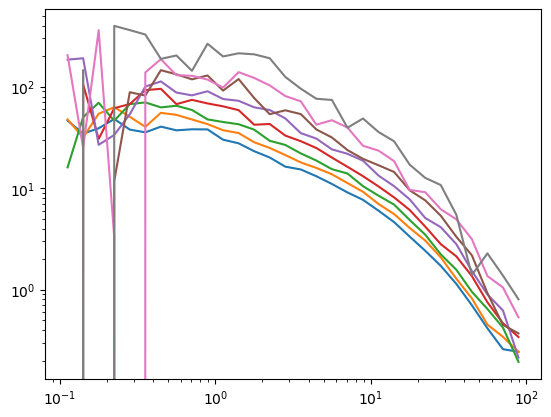

In [26]:
import matplotlib.pyplot as plt
for i in range(20, 100, 10):
    plt.plot(r_p, wp_array[ij2index(i,i)]['wp'])
plt.loglog()